<a href="https://colab.research.google.com/github/LemuelKL/CIFAR10-HOG-SVM/blob/main/CIFAR10_HOG_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import cv2
import numpy as np
from tqdm import tqdm
from statistics import mean
from joblib import dump, load
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [12]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [ ]:
data_dir = "cifar-10-batches-py"  # data obtained from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
batch_size = 10000
num_batches = 5
batches = [
    unpickle(f"{data_dir}/data_batch_{i+1}") for i in range(num_batches)
]
test_batch = unpickle(f"{data_dir}/test_batch")
X_train = np.concatenate([batch[b"data"] for batch in batches])
y_train = np.concatenate([batch[b"labels"] for batch in batches])
X_test = np.array(test_batch[b"data"])
y_test = np.array(test_batch[b"labels"])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 3072) (50000,) (10000, 3072) (10000,)


In [16]:
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)

In [20]:
class_labels = [
    "airplanes",
    "cars",
    "birds",
    "cats",
    "deer",
    "dogs",
    "frogs",
    "horses",
    "ships",
    "trucks",
]

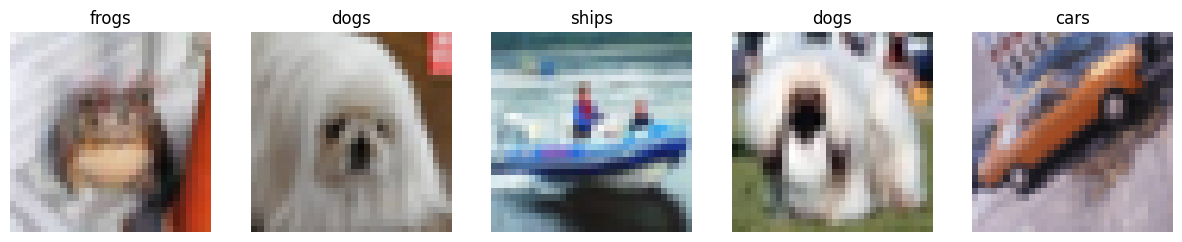

In [21]:
# Randomly plot some images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    axes[i].set_title(class_labels[y_train[idx]])
    axes[i].axis("off")
plt.show()

In [22]:
def preprocess(xs):
    hog_imgs = []
    for x in tqdm(xs):
        gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        fd = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
        )
        hog_imgs.append(fd)
    return np.array(hog_imgs)

In [24]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

100%|██████████| 10000/10000 [00:01<00:00, 7339.99it/s]


In [26]:
print(X_train.shape)
print(X_test.shape)

(50000, 324)
(10000, 324)


In [28]:
pca = PCA(0.8)
pca.fit(X_train)
print(pca.n_components_)

66


In [29]:
pipe = Pipeline(
    [
        ("standardscaler", StandardScaler()),
        ("pca", PCA(0.8)),
        ("rbfsvc", SVC(kernel="rbf", C=10, cache_size=10000)),
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)),
                ('rbfsvc', SVC(C=10, cache_size=10000))])

In [30]:
dump(pipe, "pipe.joblib")

['pipe.joblib']

In [31]:
pipe = load("pipe.joblib")

In [33]:
pipe.score(X_test, y_test)

0.6199

In [34]:
y_pred = pipe.predict(X_test)

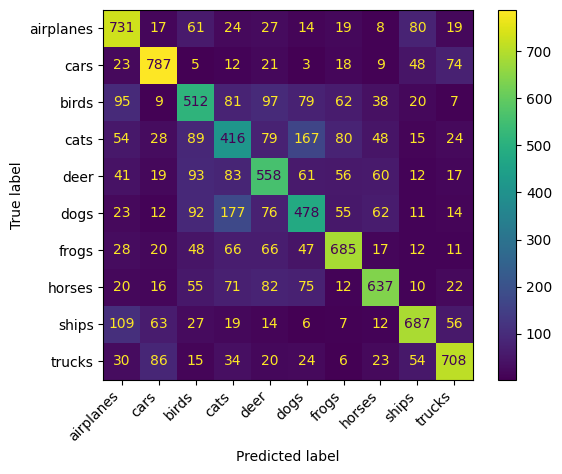

In [35]:
color = "white"
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    cm,
    display_labels=[
        "airplanes",
        "cars",
        "birds",
        "cats",
        "deer",
        "dogs",
        "frogs",
        "horses",
        "ships",
        "trucks",
    ],
)
disp.plot()
plt.xticks(rotation=45, ha="right")
plt.show()